In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

sns.set_theme("talk")
sns.set_style("white")

%matplotlib inline
%config Inline.figure_format = 'retina'

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [2]:
# Constants
N_trials = int(2001) # Need extra trial at end if starting with no pert
trial_num = np.linspace(1, N_trials, N_trials)
pert_idx = np.arange(1, N_trials, 2)
ege = np.zeros(N_trials)
rotations = np.repeat([-4, -2, 0, 2, 4], int(np.floor((N_trials / 2) / 5)))
rotations = np.random.permutation(rotations)
ege[pert_idx] = rotations
total_err_vis = np.zeros(N_trials)
total_err_ege = np.zeros(N_trials)
adapt_vis = np.zeros(N_trials)
adapt_ege = np.zeros(N_trials)
hand_angle_vis_learner = np.zeros(N_trials)
hand_angle_ege_learner = np.zeros(N_trials)
sigma_motor = 2.5 # subject's motor variability 
ige = np.random.randn(N_trials) * sigma_motor
B = -0.5 # subject's learning rate
# Analyze adaptation as function of either post- minus pre-pert trials (True)
# or as function of post- minus pert trial (False)
post_minus_pre = True

# Simulate all trials
for n in range(N_trials - 1):
    if n == 0:
        hand_angle_vis_learner[n] = ige[n]
        hand_angle_ege_learner[n] = ige[n]
        total_err_vis[n] = hand_angle_vis_learner[n] + ege[n]
        total_err_ege[n] = hand_angle_ege_learner[n] + ege[n]
    else:
        total_err_vis[n] = hand_angle_vis_learner[n] + ege[n]
        total_err_ege[n] = hand_angle_ege_learner[n] + ege[n]
    
    hand_angle_vis_learner[n + 1] = B * total_err_vis[n] + ige[n + 1]
    hand_angle_ege_learner[n + 1] = B * ege[n] + ige[n + 1]
    
    if n != 0:
        if post_minus_pre == True:
            adapt_vis[n] = hand_angle_vis_learner[n + 1] - hand_angle_vis_learner[n - 1]
            adapt_ege[n] = hand_angle_ege_learner[n + 1] - hand_angle_ege_learner[n - 1]
        else:
            adapt_vis[n] = hand_angle_vis_learner[n + 1] - hand_angle_vis_learner[n]
            adapt_ege[n] = hand_angle_ege_learner[n + 1] - hand_angle_ege_learner[n]

In [3]:
# Throw everything into a data frame
data = np.array([
    trial_num, ege, ige, total_err_vis, total_err_ege, hand_angle_vis_learner, 
    hand_angle_ege_learner, adapt_vis, adapt_ege
]).T
columns = [
    "trial_num", "ege", "ige", "total_err_vis", "total_err_ege", 
    "hand_angle_vis_learner", "hand_angle_ege_learner", "adapt_vis", 
    "adapt_ege"
]
df = pd.DataFrame(data=data, columns=columns)

In [4]:
# Truncate data frame to look at adaptation trials more easily
df_adapt = df.loc[pert_idx, :].reset_index(drop=True)
df_adapt.head()

,trial_num,ege,ige,total_err_vis,total_err_ege,hand_angle_vis_learner,hand_angle_ege_learner,adapt_vis,adapt_ege
0,2.0,-2.0,0.125658,-1.446431,-1.874342,0.553569,0.125658,1.848543,2.125327
1,4.0,0.0,-1.513624,-2.009985,-1.513624,-2.009985,-1.513624,-2.057546,-3.339323
2,6.0,-2.0,1.151916,-0.315672,-0.848084,1.684328,1.151916,1.138451,2.985607
3,8.0,-4.0,-7.378040,-11.414853,-11.378040,-7.414853,-7.378040,7.327262,2.777671
4,10.0,4.0,-0.517268,-0.217712,3.482732,-4.217712,-0.517268,-6.214890,-4.616319


In [5]:
# For regressing adaptation over total error at each level of ege:
# 1) Split data into groups defined by ege;
# 2) Bin data for each perturbation level into quintiles
df_adapt["bin_vis"] = df_adapt.groupby("ege")["total_err_vis"].transform(lambda x: pd.qcut(x, 5, labels=[1, 2, 3, 4, 5]))
df_adapt["bin_ege"] = df_adapt.groupby("ege")["total_err_ege"].transform(lambda x: pd.qcut(x, 5, labels=[1, 2, 3, 4, 5]))

# Create data frames of binned data
df_bin_vis = df_adapt.groupby(["ege", "bin_vis"])[["total_err_vis", "adapt_vis"]].mean()
df_bin_vis.reset_index(inplace=True) # flatten data frame for easier indexing

df_bin_ege = df_adapt.groupby(["ege", "bin_ege"])[["total_err_ege", "adapt_ege"]].mean()
df_bin_ege.reset_index(inplace=True)

/var/folders/42/fy648srd41l966jbjlswhljc0000gr/T/ipykernel_90639/4188102774.py:8: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_bin_vis = df_adapt.groupby(["ege", "bin_vis"])[["total_err_vis", "adapt_vis"]].mean()
/var/folders/42/fy648srd41l966jbjlswhljc0000gr/T/ipykernel_90639/4188102774.py:11: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_bin_ege = df_adapt.groupby(["ege", "bin_ege"])[["total_err_ege", "adapt_ege"]].mean()


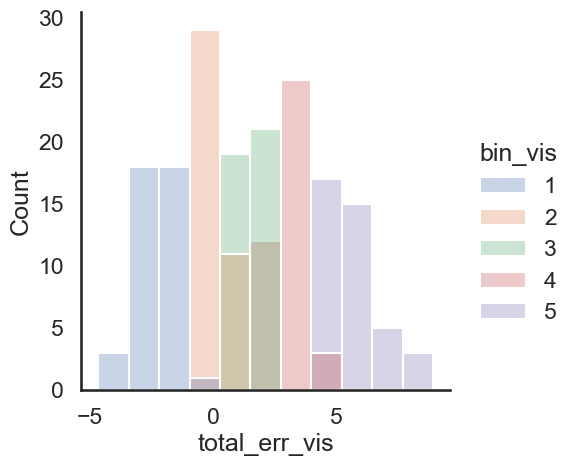

In [6]:
# Plot histogram at one level of ege to make sure binning was properly applied
mask = df_adapt["ege"] == 2
df_test_bin = df_adapt.loc[mask, :]
sns.displot(df_test_bin, x="total_err_vis", hue="bin_vis", alpha=0.3);

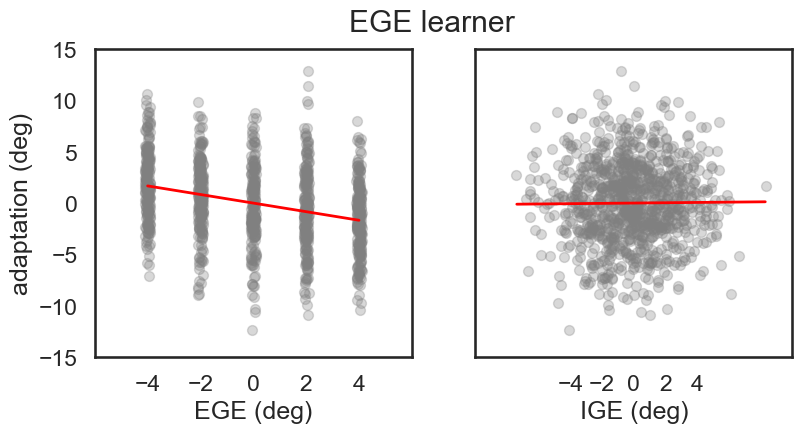

In [7]:
# EGE learner - plot adaptation vs ege and adaptation vs ige
fig, ax = plt.subplots(1, 2, figsize=(9, 4), sharey=True)
sns.regplot(data=df_adapt, ax=ax[0], x="ege", y="adapt_ege", x_jitter=0.1, 
               scatter_kws=dict(alpha=0.3, color='gray', s=50), 
               line_kws=dict(linewidth=2, color='red'), ci=None)
ax[0].set(ylim=(-10, 10), xlim=(-6, 6), xticks=[-4, -2, 0, 2, 4], alpha=0.1, 
      xlabel="EGE (deg)", ylabel="adaptation (deg)");

# For IGE
sns.regplot(data=df_adapt, ax=ax[1], x="ige", y="adapt_ege", x_jitter=0.1, 
               scatter_kws=dict(alpha=0.3, color='gray', s=50), 
               line_kws=dict(linewidth=2, color='red'), ci=None)
ax[1].set(ylim=(-15, 15), xlim=(-10, 10), xticks=[-4, -2, 0, 2, 4], alpha=0.1, 
      xlabel="IGE (deg)", ylabel=None)
fig.suptitle("EGE learner");


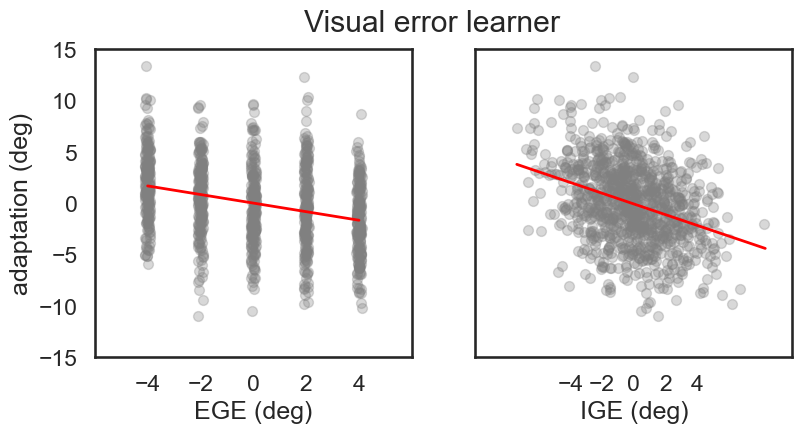

In [8]:
# Total error learner - plot adaptation vs ege and adaptation vs ige
fig, ax = plt.subplots(1, 2, figsize=(9, 4), sharey=True)
sns.regplot(data=df_adapt, ax=ax[0], x="ege", y="adapt_vis", x_jitter=0.1, 
               scatter_kws=dict(alpha=0.3, color='gray', s=50), 
               line_kws=dict(linewidth=2, color='red'), ci=None)
ax[0].set(ylim=(-10, 10), xlim=(-6, 6), xticks=[-4, -2, 0, 2, 4], alpha=0.1, 
      xlabel="EGE (deg)", ylabel="adaptation (deg)");

# For IGE
sns.regplot(data=df_adapt, ax=ax[1], x="ige", y="adapt_vis", x_jitter=0.1, 
               scatter_kws=dict(alpha=0.3, color='gray', s=50), 
               line_kws=dict(linewidth=2, color='red'), ci=None)
ax[1].set(ylim=(-15, 15), xlim=(-10, 10), xticks=[-4, -2, 0, 2, 4], alpha=0.1, 
      xlabel="IGE (deg)", ylabel=None)
fig.suptitle("Visual error learner");

In [9]:
# Further groupby in order to extract average adaptation for each level of ege
df_bin_avg_ege = df_bin_ege.groupby("ege")["adapt_ege"].mean().reset_index()
df_bin_avg_vis = df_bin_vis.groupby("ege")["adapt_vis"].mean().reset_index()

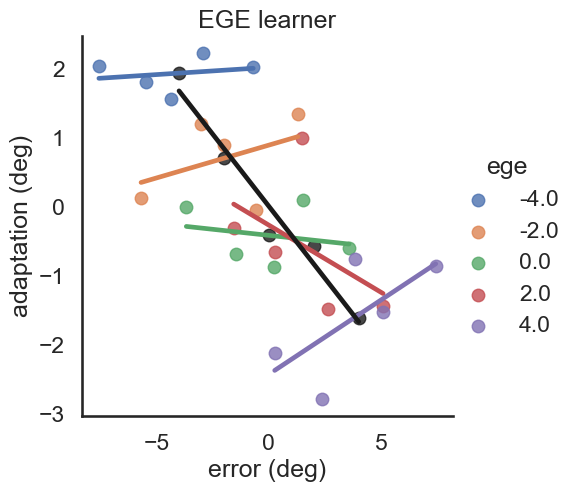

In [10]:
# Plot EGE learner
g = sns.lmplot(data=df_bin_ege, x="total_err_ege", y="adapt_ege", hue="ege", ci=None)
sns.regplot(x=df_bin_avg_ege["ege"], y=df_bin_avg_ege["adapt_ege"], ci=None, color="k")
g.set(alpha=0.1, xlabel="error (deg)", ylabel="adaptation (deg)", title="EGE learner");

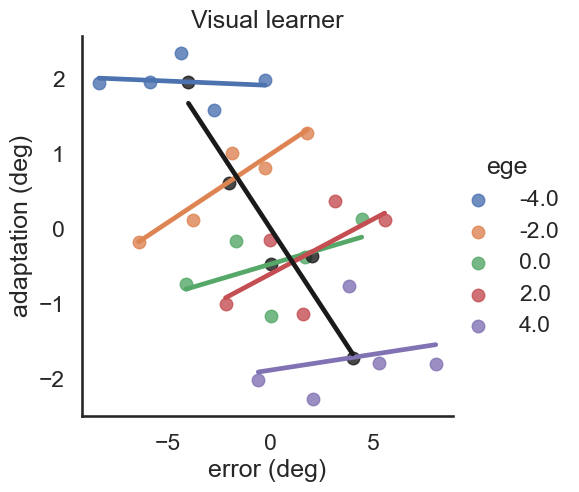

In [11]:
# Plot 
g = sns.lmplot(data=df_bin_vis, x="total_err_vis", y="adapt_vis", hue="ege", ci=None)
sns.regplot(x=df_bin_avg_vis["ege"], y=df_bin_avg_vis["adapt_vis"], ci=None, color="k")
g.set(alpha=0.1, xlabel="error (deg)", ylabel="adaptation (deg)", title="Visual learner");